# Time series extraction for a specific location

This example demonstrates the extraction of time series data for the variable "plant available water"  
from a depth of 13 meters for the year 2023. The data will be extracted for two locations:  
Location 1 in Jülich, latitude: 50.93486, longitude: 6.394616     
Location 2 in Amsterdam, latitude 52.37677, longitude: 5.04244   
The time series saved as an ASCII file.

After extracting the time series, the results will be used to plot the daily plant available water during 2023. 

First, we have to make the tool available to import by Python. If you already have added it to your PYHTONPATH, below step is not needed.

In [1]:
import os
import sys

cwd = os.getcwd()
tool_path = f"{cwd}/ParFlow_data_extraction_tool"
sys.path.append(tool_path)


then, we need to import all libraries needed in the example.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import data_extraction_tool

Before running the tool we have to read in some data that we can apply the data extraction. For this example we take some data available in ../data/ directory. In particular, data_input_example_1.json and DE-0055_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGRvector_newAllv.nc 

In [3]:
data_input = f'{tool_path}/examples/data_input_example_1.json'
lls_indicators = f'{tool_path}/data/DE-0055_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGRvector_newAllv.nc'

After that we extract the data by choosing the function data_extraction_csv() from the tool.

In [4]:
data_extraction_tool.data_extraction_csv(data_input,lls_indicators)

Location: Jülich
Found:
Mapped x index: 641
Mapped y index: 1118
data for Lat:50.93686, Lon:6.36174 is extracted and being written in a CSV file
csv file saved
 
Location: Amsterdam
Found:
Mapped x index: 537
Mapped y index: 1401
The chosen location is located directly on a lake, river or sea, please insert a different location.


A timeseries was extracted for the first location "Jülich" and the results can be seen in Station_Jülich_ADAPTER_DE05_ECMWF-HRES-forecast_FZJ-IBG3-ParFlowCLM380_v04aJuwelsGpuProd_paw_17.0m-depth_20230102-20240101.csv in ../exmaples.

The reason that no time series was extracted for location "Amsterdam", is that the location and the neighbroing grid points fall directly on lake, river or a sea.

After extracting the time series, the results are plotted.


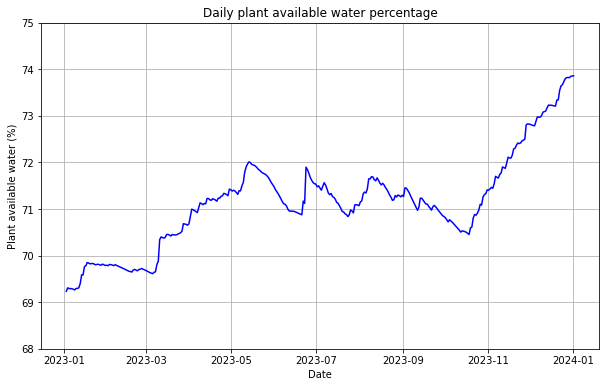

In [5]:
csv_data = f'{cwd}/Station_Jülich_ADAPTER_DE05_ECMWF-HRES-forecast_FZJ-IBG3-ParFlowCLM380_v04aJuwelsGpuProd_paw_17.0m-depth_20230102-20240101.csv'
# Create a Pandas DataFrame from the CSV data
data = pd.read_csv(csv_data, skiprows=9, names=['Date', 'Plant available water'], parse_dates=['Date'])
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Plant available water'], color='b', linestyle='-')
plt.ylim(68,75)
plt.title('Daily plant available water percentage')
plt.xlabel('Date')
plt.ylabel('Plant available water (%)')
plt.grid(True)
plt.show()